In [231]:
import json
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler

In [232]:
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import networkx as nx
from collections import defaultdict
from itertools import combinations
import math
import time
import dwave_networkx as dnx
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import networkx as nx
from collections import defaultdict
from itertools import combinations
import math
import time
import dwave_networkx as dnx
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite
import json
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler
from numpy import *
from math import *
from random import *

In [233]:
# Please enter the S3 bucket you created during onboarding in the code below
my_bucket = f"amazon-braket-qbraid-jobs" # the name of the bucket
my_prefix = "mazhandufarai-40gmail-2ecom" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)
# session and device
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6")
print('Device:', device)

Device: Device('name': DW_2000Q_6, 'arn': arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6)


In [234]:
# helper function to plot graph
def get_graph(graph, pos):
    """
    plot colored graph for given solution
    """
    # positions for all nodes
    # pos = nx.spring_layout(graph)

    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=400)

    # edges
    nx.draw_networkx_edges(graph, pos)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=20, font_family='sans-serif')

    # plot the graph
    plt.axis('off')
    #plt.savefig("figures/random_graph.png") # save as png
    plt.show();

In [235]:
# helper function to plot graph
def get_colored_graph(graph, pos, colors):
    """
    plot colored graph for given solution
    """
    
    # positions for all nodes
    # pos = nx.spring_layout(graph)
    
    colorlist = ['#377eb8', '#e41a1c']
    nx.draw_networkx(graph, pos, node_color=[colorlist[colors[int(node)]] for node in graph.nodes],
                     node_size=400, font_weight='bold', font_color='w')
    # plot the graph
    plt.axis('off');
    # plt.savefig("./figures/weighted_graph.png") # save as png

Graph on 4 nodes created with 6 out of 6.0 possible edges.


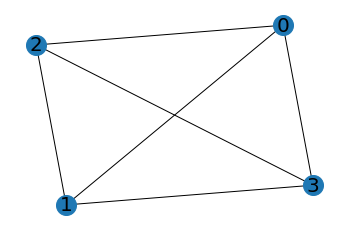

alpha [10, 4, 1, 1, 7, 9]
bh1 [7, 5, 9]
bh2 [196, 181]
[[10, 7, 181, 0, 181, 0], [7, 4, 0, 196, 0, 196], [181, 0, 1, 5, 5, 0], [0, 196, 5, 1, 5, 196], [181, 0, 5, 5, 7, 0], [0, 196, 0, 196, 0, 9]]


In [236]:
# Copyright 2019 D-Wave Systems, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# ------- Set tunable parameters -------
num_reads = 1000
gamma = 80

# ------- 8 up our graph -------
vertices = 4
G = nx.gnp_random_graph(vertices, 1)

print("Graph on {} nodes created with {} out of {} possible edges.".format(len(G.nodes), 
                                                                           len(G.edges), 
                                                                           len(G.nodes) * (len(G.nodes)-1) / 2))
# for i in range len(G.edges):
#     for j in range len(i,G.edges):
#         if i==j:
#             Q[(u,v)]=i
#         elif:
#             x=i\\4
#             y=j\\4
            
            
# ------- Plot our graph -------
pos = nx.spring_layout(G)
# plot graph with labels
get_graph(G, pos)

# ------- Set up our QUBO dictionary -------

# Initialize our Q matrix
Q = defaultdict(int)

# Fill in Q matrix
# for u, v in G.edges:
#     Q[(u,u)] += 1
#     Q[(v,v)] += 1
#     Q[(u,v)] += -2

# alpha = [1.99,-0.01,-0.01,1.99]
# alpha = [3,5,1,7,3,2]
# alpha = [-0.01,1.99,-0.01,3.99,-0.01,0.99]
epsilon = 0.01
# Minimum between alpha[0] and alpha[2]-epsilon
# Minimum between alpha[1] and alpha[2]-epsilon
# bh1 = [1,2]  #importance from Edgar
bh2 = [200,100,50]
row = 3
col = 2
alpha=[]
bh1=[]
bh2=[]
for i in range(row*col):
    alpha.append(randint(1,10))
print("alpha",alpha)
for i in range(row):
    bh1.append(randint(1,10))
print("bh1",bh1)
for i in range(col):
    bh2.append(randint(100,200))
print("bh2",bh2)
# cur = 0
Q = [[0 for i in range(col*row)] for j in range(row*col)]
for i in range (row*col):
    for j in range (col*row):
        if i==j:
            Q[i][j] = alpha[i]
        else:
            a=(i+1)//(col+1)
            b=(j+1)//(col+1)
            if a==b:
                Q[i][j]=bh1[a]
            else:
                a=(i+1)%col
                b=(j+1)%col
                if a==b:
                    Q[i][j]=bh2[a]
                else:
                    Q[i][j]=0
                # x[i][j]=bh[i]
print(Q)

# for i in G.nodes:
#     Q[(i,i)] += gamma*(1-len(G.nodes))

# for i, j in combinations(G.nodes, 2):
#     Q[(i,j)] += 2*gamma

In [237]:
# ------- Run our QUBO on the QPU -------

# Set chain strength
chain_strength = gamma*len(G.nodes)

# Run the QUBO on Braket
start = time.time()

# sampler = BraketDWaveSampler(s3_folder,"arn:aws:braket:::device/qpu/d-wave/Advantage_system4")
sampler = BraketDWaveSampler(s3_folder,"arn:aws:braket:::device/qpu/d-wave/Advantage_system4")
sampler = EmbeddingComposite(sampler)
response = sampler.sample_qubo(Q, chain_strength=chain_strength, num_reads=num_reads)

# See if the best solution found is feasible, and if so print the number of cut edges.
# sample = response.record.sample[0]
sample = response.record.sample

print(sample)
# In the case when n is odd, the set may have one more or one fewer nodes
# if sum(sample) in [math.floor(len(G.nodes)/2), math.ceil(len(G.nodes)/2)]:
#     num_cut_edges = 0
#     for u, v in G.edges:
#         num_cut_edges += sample[u] + sample[v] - 2*sample[u]*sample[v]
#     print("Valid partition found with", num_cut_edges, "cut edges.")
# else:
#     print("Invalid partition.")


# print execution time
end = time.time()
print('Code execution time [sec]:', end - start)


[[0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 1 0 0 0 0]
 [0 1 1 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]
 [0 0 1 0 0 1]
 [1 0 0 0 0 0]
 [1 0 0 1 0 0]
 [0 1 0 0 1 0]
 [0 0 1 1 0 0]
 [0 0 0 0 1 1]
 [0 0 1 0 1 0]
 [0 0 0 1 1 0]
 [1 0 0 0 0 1]
 [0 1 1 0 1 0]
 [0 0 1 0 1 1]
 [1 1 0 0 0 0]
 [0 0 1 1 1 0]]
Code execution time [sec]: 11.94725513458252


In [238]:
# print(sample)
if type(sample) != list:
    sample=sample.tolist()


for res in list(sample):
    m = []
    while res != []:
        m.append(res[:col])
        res = res[col:]
    m=transpose(m)
    
    k=0
    comp=True
    while k<len(m) and comp==True:
        if 1 not in m[k]:
            comp=False
        k+=1
    # print(m)
    if comp==True:
        m=transpose(m)
        print(m)
        break


for coll in range(len(m[0])):
    x = 0
    for roww in range(len(m)):
        if m[roww][coll] == 1 and x == 0:
            print("Patient ", coll+1, " to hospital ", roww+1)
            x = 1

[[0 1]
 [1 0]
 [0 0]]
Patient  1  to hospital  2
Patient  2  to hospital  1
